<a href="https://colab.research.google.com/github/fitriindra/BigDataCourseExamples/blob/master/PySpark_EDA_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Contoh proses EDA (Exploratory Data Analysis) pada Dataset Titanic**

Proses EDA seharusnya dilakukan untuk semua kolom supaya informasi data, sebaran data diketahui sehingga dapat dilakukan *pre-processing* sebelum data dapat diolah menggunakan pemrosesan Big Data (misal MapReduce, *Transformations* dan *Actions* pada RDD, DataFrame, SparkSQL maupun SparkML (*Machine Learning*)

Supaya contoh EDA tidak terlalu rumit, pada contoh ini hanya ada satu contoh pemrosesan data pada kolom Age (umur penumpang). Anda diharapkan melakukan proses EDA terhadap  data sesuai kolom-kolom yang ada pada dataset yang Anda pilih

# **1. Instalasi Spark pada Google Colab**
kode di bawah ini hanya dijalankan **satu kali saja** saat runtime pertama kali dijalankan



In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# **2. Import library Spark yang sudah diinstal**

In [3]:
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import col, avg

**(Opsional) Instalasi Library pyspark_dist_explore**
Library ini digunakan untuk menampilkan plot dari Spark DataFrame.
Anda dapat menggunakan library lain, misal matplotlib, seaborn, dll

In [4]:
!pip install -q pyspark_dist_explore

In [5]:
import matplotlib.pyplot as plt
from pyspark_dist_explore import Histogram, hist

# **3. Inisialisasi SparkContext dan SparkSession**

In [6]:
sc = spark.sparkContext
spark = SparkSession(sc)



# **4. Load Dataset**

Dataset berupa file CSV di-load. Lokasi file csv sama dengan lokasi file kode program

In [7]:
titanic_df = spark.read.csv("TitanicData.csv", header=True, inferSchema=True)
titanic_df.printSchema()            #mengecek schema dari dataset

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



# **5. Proses EDA**


Pertama kita cek jumlah total data penumpang pada dataset Titanic 

In [8]:
print("Jumlah total penumpang:")
titanic_df.count()


Jumlah total penumpang:


891

Kita gunakan fungsi ``` describe()``` untuk mengetahui statistik data. Pada contoh ini kita cek statistik dari data pada kolom ```Age```.


In [9]:
titanic_df.select('Age').describe().show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               714|
|   mean| 29.69911764705882|
| stddev|14.526497332334035|
|    min|              0.42|
|    max|              80.0|
+-------+------------------+



Untuk melihat perseberan data pada kolom ```Age```, kita plot Histogram data. Hasil plot adalah sebagai berikut:

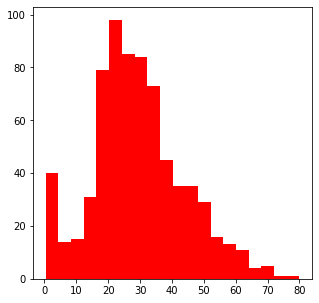

In [10]:
titanic_df_age = titanic_df.select('Age')

fig, axes = plt.subplots()
fig.set_size_inches(5, 5)
hist(axes, titanic_df_age, bins=20, color="red")
plt.show()

Dapat kita lihat dari sebaran data di atas, tidak terdapat data *outlier*, karena nilai umur > 0 dan < 80 sehingga data umur adalah **valid** (tidak terdapat *outlier*) 

Apabila dilihat pada statistik yang kita lihat menggunakan fungsi ```describe()```, data pada kolom ```Age``` hanya berjumlah ```714```, sementara saat kita menghitung jumlah penumpang di awal jumlah total data adalah ```891```. Karena ada data yang "hilang" dari statistik maka kita cek apakah ada data yang ```null``` (kosong)

In [11]:
print("Jumlah total penumpang dengan kolom Age kosong(null):")
titanic_df.where(col("Age").isNull()).count()

Jumlah total penumpang dengan kolom Age kosong(null):


177

Berdasarkan kode di atas, ada ```177``` baris data dengan nilai ```Age = null```.

Karena terdapat data null, maka perlu dilakukan *pre-processing* pada data kolom ```Age```. Apabila tidak dilakukan *pre-processing*, maka hasil analisa pada proses selanjutnya akan mengalami kesalahan.

# **6. *Pre-processing* Data**

Data bernilai ```null``` pada kolom ```Age``` berjumlah banyak, oleh karena itu akan mempengaruhi proses analisa data. Oleh karena itu, perlu dilakukan pengisian ```value``` pada kolom ```Age```. 

Pengisian data bisa dilakukan dengan beberapa cara, misalnya mengganti nilai ```null``` dengan nilai ```0```, mengganti dengan nilai baris sebelumnya, menggunakan ```mean``` (rata-rata), dan lain-lain.

Salah satu cara pengisian adalah dengan menggunakan nilai ```mean``` (rata-rata) dari kolom tersebut. Kita akan menggunakan cara ini karena cara lain kurang sesuai: penggantian dengan nilai ```0``` akan tetap membuat data tidak valid karena umur ```0``` artinya penumpang belum lahir, penggantian dengan nilai baris sebelumnya juga tidak valid karena akan mempengaruhi statistik data.

In [12]:
mean_age = titanic_df.agg(avg(col("Age"))).first()
print("rata-rata umur penumpang", mean_age[0])
titanic_df = titanic_df.na.fill(mean_age[0], ["Age"])

rata-rata umur penumpang 29.69911764705882


setelah mengisi data ```null``` dengan nilai rata-rata, sekarang kita cek apakah masih ada data yang kosong

In [13]:
print("Jumlah total penumpang dengan kolom Age kosong(null):")
titanic_df.where(col("Age").isNull()).count()

Jumlah total penumpang dengan kolom Age kosong(null):


0

In [14]:
titanic_df.select('Age').describe().show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               891|
|   mean|29.699117647058763|
| stddev|13.002015226002891|
|    min|              0.42|
|    max|              80.0|
+-------+------------------+



Karena data sudah dilakukan pre-processing maka data ```Age``` sudah siap untuk dilakukan analisa pada proses selanjutnya

In [15]:
spark.stop()    #digunakan untuk menghentikan SparkSession